# Text Classification with Naive Bayes, Logistic Regression, SVM

**Overview:** This notebook aims to give you a brief overview of performing text classification using Naive Bayes, Logistic Regression and Support Vector Machines. Our goal in this notebook is to explore the process of training and testing text classifiers for this problem, using this data set and two text classification algorithms: Multinomial Naive Bayes and Logistic Regression, implemented in sklearn. 

<br><br>
Let's import few necessary packages before we start our work

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd # to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

# import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

### Section 1: Load and explore the dataset

In [2]:
import os

our_data = pd.read_csv(os.path.join('/home/victor/DemoProjects/helpdesk_nlp/downloads', 'dataset_clean.csv'))

#### Remove nulls and empty texts

In [3]:
def filter_dataset(df):
    df = df[(df['language'] == 'en') & (df['text'] != '') & (df['c1'].notnull())]
    return df

print(our_data.shape)

our_data = filter_dataset(our_data)

print(our_data.shape)

(5163, 9)
(5159, 9)


In [4]:
display(our_data.shape) # Number of rows (instances) and columns in the dataset
our_data["c1"].value_counts()/our_data.shape[0] # Class distribution in the dataset

(5159, 9)

rest           0.969955
development    0.030045
Name: c1, dtype: float64

There is an imbalance in the data with **rest** being 96% in the dataset.

In [5]:
# convert c1 to a numerical variable
our_data['label'] = our_data.c1.map({'development':1, 'rest':0}) # development is 1, rest is 0. 
our_data = our_data[["text","label"]] # Let us take only the two columns we need.
our_data.shape

(5159, 2)

### Section 2: Text Pre-processing

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task. 

In [6]:
def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stop_words])
    # remove punctuation and numbers
    return doc

### Section 3: Modeling

Now we are ready for the modelling. We are going to use algorithms from sklearn package. We will go through the following steps:

1 Split the data into training and test sets (75% train, 25% test)    
2 Extract features from the training data using CountVectorizer, which is a bag of words feature  implementation. We will use the pre-processing function above in conjunction with Count Vectorizer  
3 Transform the test data into the same feature vector as the training data.  
4 Train the classifier  
5 Evaluate the classifier  

In [7]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
X = our_data.text # the column text contains textual data to extract features from
y = our_data.label # this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5159,) (5159,)
(3869,) (3869,)
(1290,) (1290,)


In [8]:
# Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
# i.e., the dimension of our feature vector is 19089!

(3869, 18908) (1290, 18908)


In [9]:
# Step 3: Train the classifier and predict for test data
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

Accuracy:  0.9658914728682171
ROC_AOC_Score:  0.49864281669237825


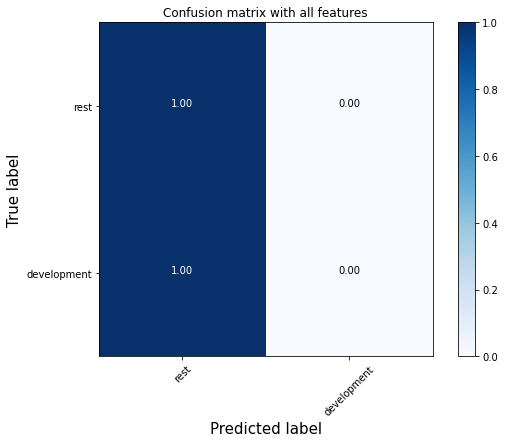

In [10]:
# Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['rest','development'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

At this point, we can notice that the classifier is doing poorly with identifying development tickets because of the unbalance. Let us change the count vectorizer to take a certain number of features as maximum. 

CPU times: user 1.17 ms, sys: 0 ns, total: 1.17 ms
Wall time: 1.18 ms
Accuracy:  0.9550387596899225


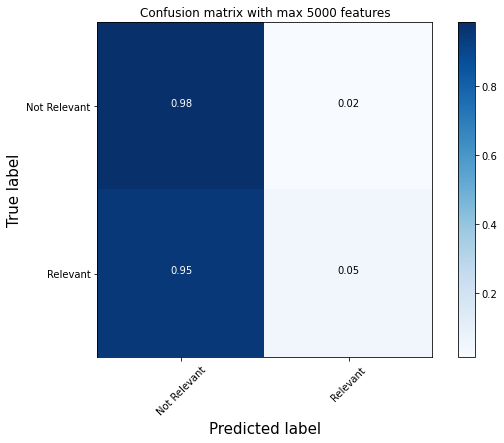

In [11]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

Let us try another classification algorithm and see if the performance changes. For this experiment, we have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset.

Accuracy:  0.9434108527131783
AUC:  0.49864281669237825


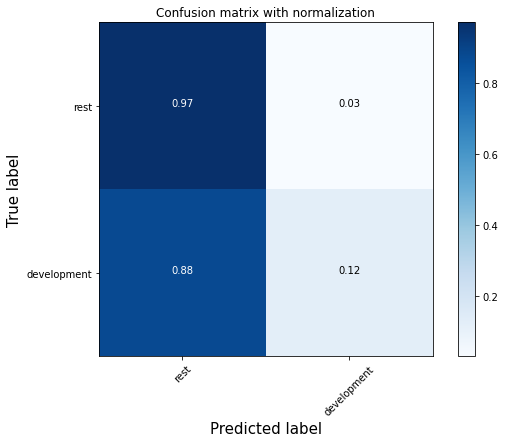

In [12]:
from sklearn.linear_model import LogisticRegression # import

logreg = LogisticRegression(class_weight="balanced") # instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['rest','development'],normalize=True,
                      title='Confusion matrix with normalization')

Let us wrap this notebook by trying with one more classifier, but reducing the feature vector size to 1000.

Accuracy:  0.9217054263565891
AUC:  0.49864281669237825


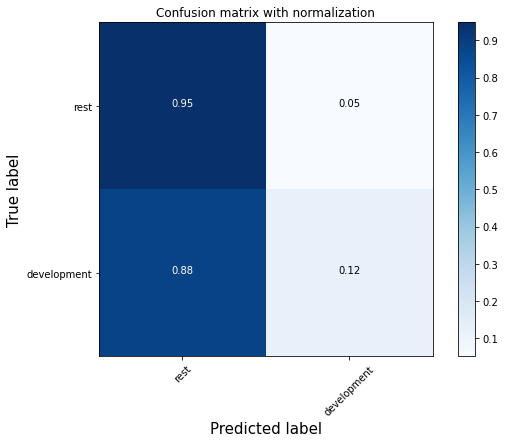

In [13]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') # instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['rest','development'],normalize=True,
                      title='Confusion matrix with normalization')

#### TODO Explain here the summary